In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

dv = 0.001

klin =0

nband = 520

ng =8

ng_adju = (/ 0 , -1 /) 

ng_refs = (/ 3 , 2 , 3 /) 

nref =3

nv = 1000

nv = 1000

option_compute_btable = 1

option_compute_ktable =0

option_klin =0

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 1 , 10 , 500 /) 

t_refs = (/ 250 , 250 , 250 /) 

tsfc =294

vstar = 1380

data w_diffuse
     &     /1.66 , 1.66 , 166 , 1.66,
     &     1.66 , 1.66 , 1.66 , 1.66/

data wgt
     &     /0.55 , 0.55 , 0.85 , 0.85,
     &     0.85 , 0.0 , 0.3 , 0.55/

atmosphere_profiles/mls75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

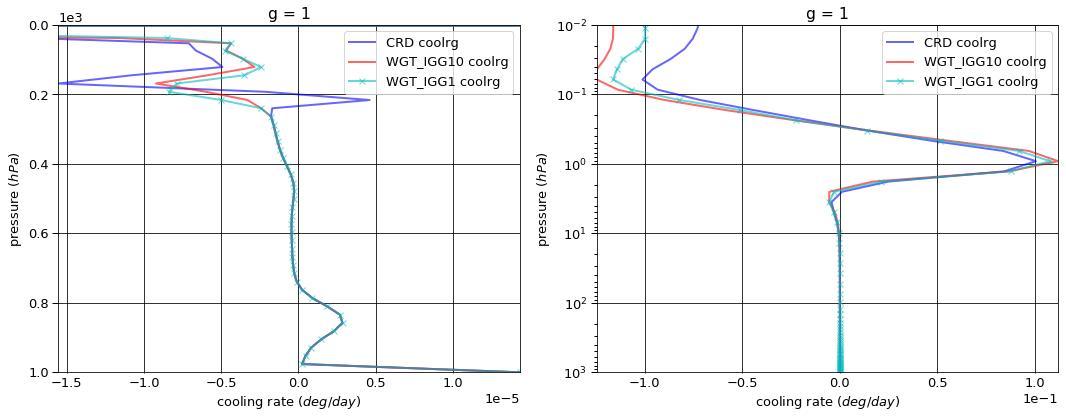

# Figure: cooling rate g-group 2

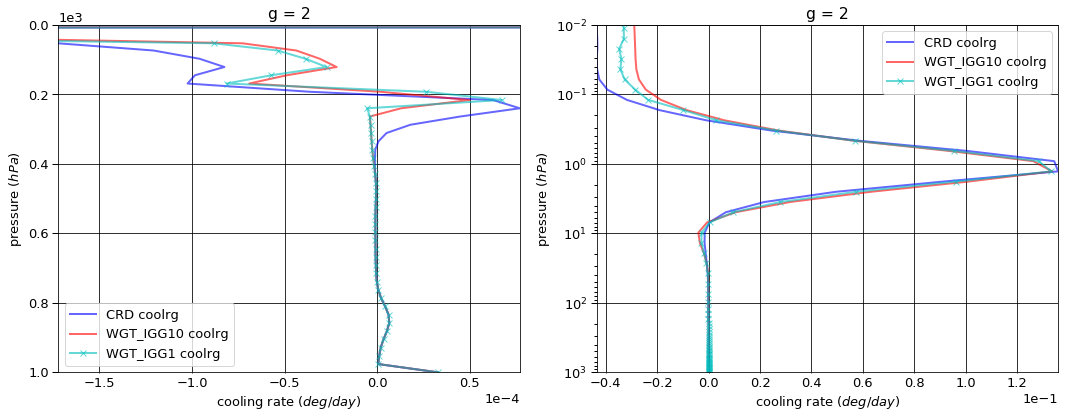

# Figure: cooling rate g-group 3

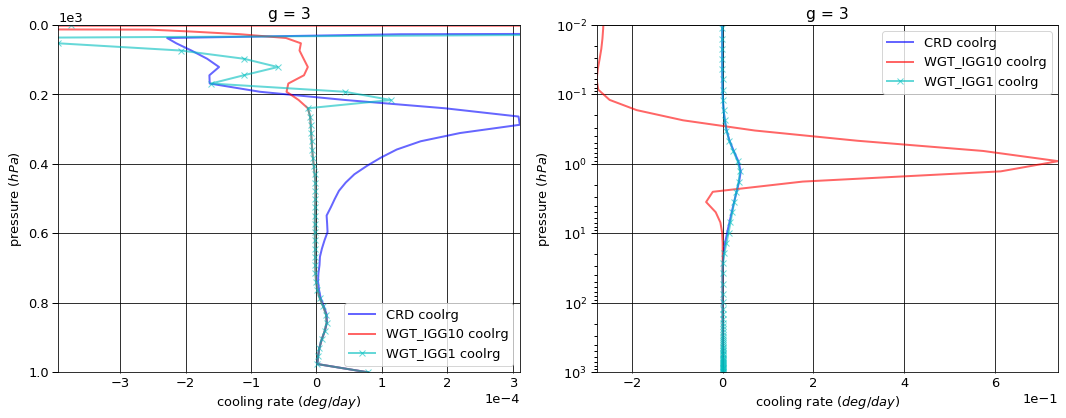

# Figure: cooling rate g-group 4

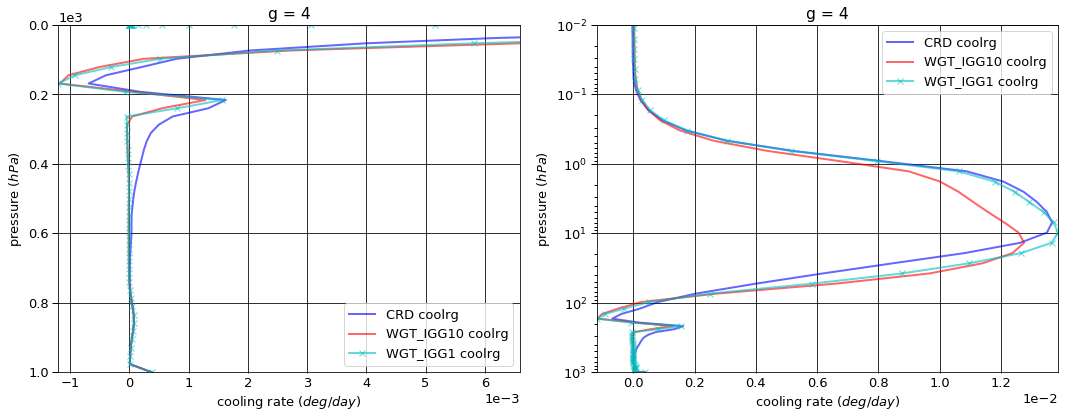

# Figure: cooling rate g-group 5

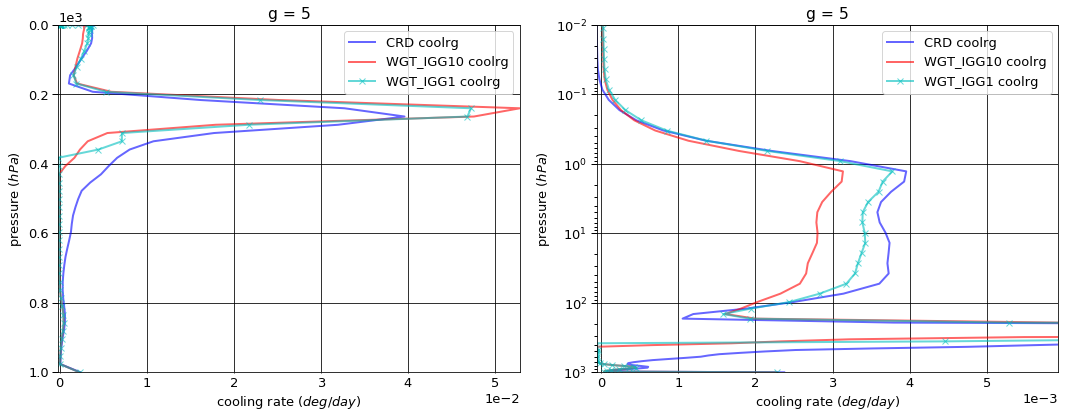

# Figure: cooling rate g-group 6

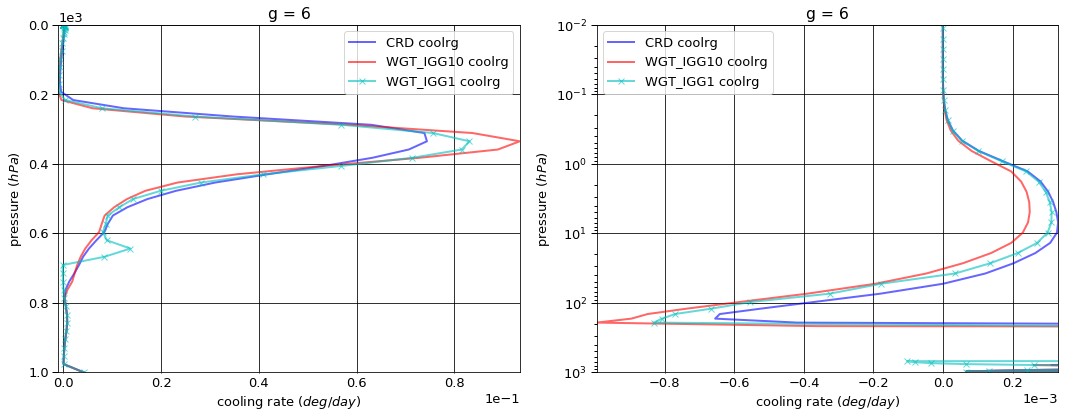

# Figure: cooling rate g-group 7

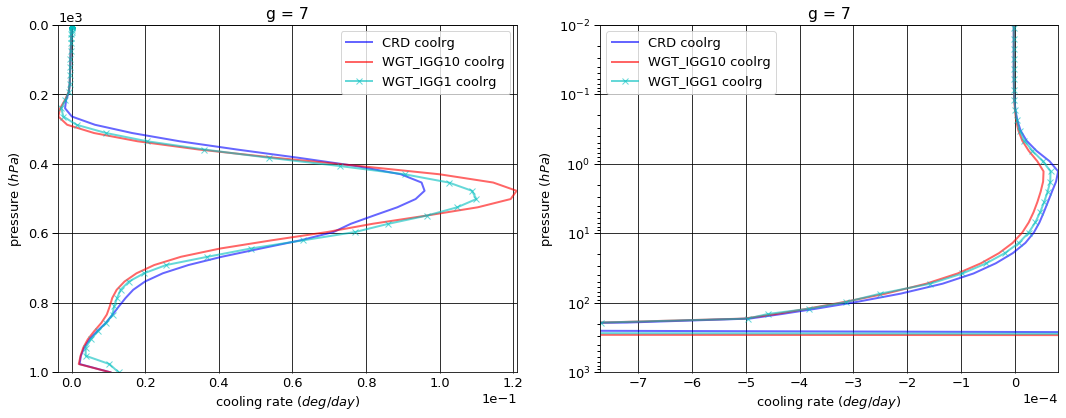

# Figure: cooling rate g-group 8

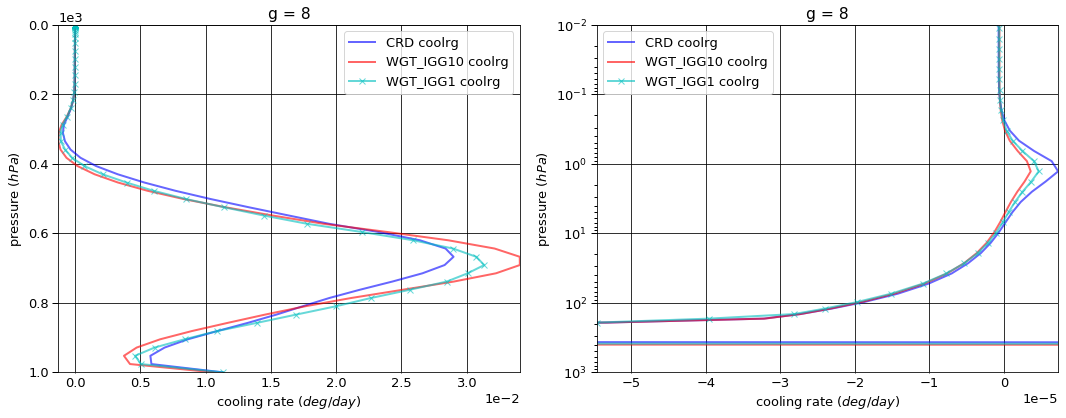

# Figure: cooling rate g-group total

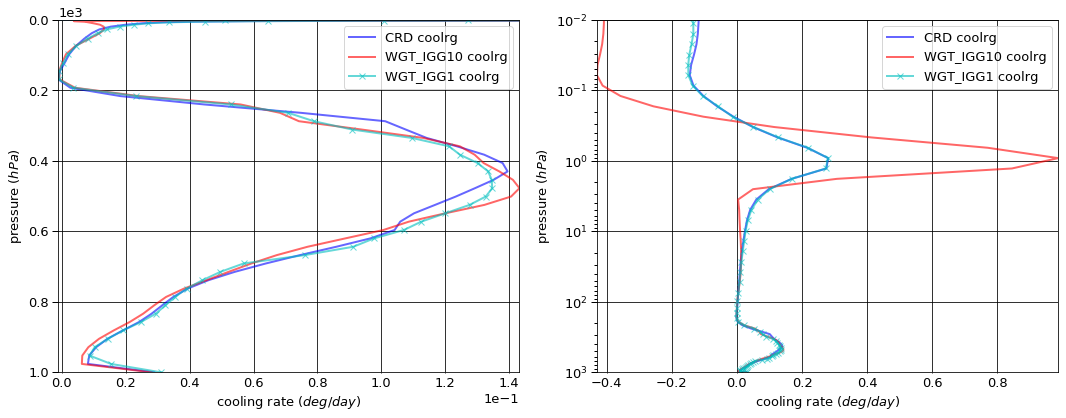

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.008894   0.000000 -0.008894
  1013.0   76     -0.034574   0.034534 -0.000040
2 0.0      1      -0.026380   0.000000 -0.026380
  1013.0   76     -0.078580   0.078489 -0.000091
3 0.0      1      -0.031929   0.000000 -0.031929
  1013.0   76     -0.188777   0.188557 -0.000220
4 0.0      1      -0.085135   0.000000 -0.085135
  1013.0   76     -0.909609   0.908550 -0.001059
5 0.0      1      -0.629380   0.000000 -0.629380
  1013.0   76     -5.496186   5.489547 -0.006639
6 0.0      1      -1.787734   0.000000 -1.787734
  1013.0   76    -10.025001  10.013326 -0.011676
7 0.0      1      -3.542791   0.000000 -3.542791
  1013.0   76    -11.606732  11.579048 -0.027684
8 0.0      1      -1.162848   0.000000 -1.162848
  1013.0   76     -2.390157   2.344731 -0.045426


WGT_IGG10


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.008401   0.000000 -0.008401
  1013.0   76     -0.034574   0.034534 -0.000040
2 0.0      1      -0.028410   0.000000 -0.028410
  1013.0   76     -0.078580   0.078489 -0.000091
3 0.0      1      -0.072438   0.000000 -0.072438
  1013.0   76     -0.188777   0.188557 -0.000220
4 0.0      1      -0.080210   0.000000 -0.080210
  1013.0   76     -0.909609   0.908552 -0.001057
5 0.0      1      -0.522340   0.000000 -0.522340
  1013.0   76     -5.496186   5.489806 -0.006380
6 0.0      1      -1.783909   0.000000 -1.783909
  1013.0   76    -10.025001  10.013326 -0.011676
7 0.0      1      -3.552295   0.000000 -3.552295
  1013.0   76    -11.606732  11.579487 -0.027245
8 0.0      1      -1.162613   0.000000 -1.162613
  1013.0   76     -2.390157   2.356572 -0.033585


WGT_IGG1


flug       fldg     fnetg
g pressure level                                
1 0.0      1      -0.008585   0.000000 -0.008585
  1013.0   76     -0.034574   0.034534 -0.000040
2 0.0      1      -0.027632   0.000000 -0.027632
  1013.0   76     -0.078580   0.078489 -0.000091
3 0.0      1      -0.032344   0.000000 -0.032344
  1013.0   76     -0.188777   0.188557 -0.000220
4 0.0      1      -0.081332   0.000000 -0.081332
  1013.0   76     -0.909609   0.908552 -0.001057
5 0.0      1      -0.528553   0.000000 -0.528553
  1013.0   76     -5.496186   5.489806 -0.006380
6 0.0      1      -1.804209   0.000000 -1.804209
  1013.0   76    -10.025001  10.013326 -0.011676
7 0.0      1      -3.592482   0.000000 -3.592482
  1013.0   76    -11.606732  11.593377 -0.013355
8 0.0      1      -1.172098   0.000000 -1.172098
  1013.0   76     -2.390157   2.351604 -0.038553


WGT_IGG10 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      4.931568e-04  0.000000  4.931568e-04
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
2 0.0      1     -2.029067e-03  0.000000 -2.029067e-03
  1013.0   76     0.000000e+00  0.000000  1.355253e-20
3 0.0      1     -4.050927e-02  0.000000 -4.050927e-02
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
4 0.0      1      4.924383e-03  0.000000  4.924383e-03
  1013.0   76     0.000000e+00  0.000002  1.872200e-06
5 0.0      1      1.070399e-01  0.000000  1.070399e-01
  1013.0   76     0.000000e+00  0.000259  2.592058e-04
6 0.0      1      3.824800e-03  0.000000  3.824800e-03
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
7 0.0      1     -9.503600e-03  0.000000 -9.503600e-03
  1013.0   76     1.776357e-15  0.000439  4.385250e-04
8 0.0      1      2.341000e-04  0.000000  2.341000e-04
  1013.0   76     0.000000e+00  0.011842  1.184149e-02


WGT_IGG1 - CRD


flug      fldg         fnetg
g pressure level                                      
1 0.0      1      3.087544e-04  0.000000  3.087544e-04
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
2 0.0      1     -1.251282e-03  0.000000 -1.251282e-03
  1013.0   76     0.000000e+00  0.000000  1.355253e-20
3 0.0      1     -4.146430e-04  0.000000 -4.146430e-04
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
4 0.0      1      3.802660e-03  0.000000  3.802660e-03
  1013.0   76     0.000000e+00  0.000002  1.872200e-06
5 0.0      1      1.008271e-01  0.000000  1.008271e-01
  1013.0   76     0.000000e+00  0.000259  2.592058e-04
6 0.0      1     -1.647500e-02  0.000000 -1.647500e-02
  1013.0   76     0.000000e+00  0.000000  0.000000e+00
7 0.0      1     -4.969110e-02  0.000000 -4.969110e-02
  1013.0   76     1.776357e-15  0.014329  1.432895e-02
8 0.0      1     -9.250000e-03  0.000000 -9.250000e-03
  1013.0   76     0.000000e+00  0.006873  6.873353e-03

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1     -8.536152e-02
  1001.112500 75     1.434013e-05
2 0.000312    1     -4.483841e-02
  1001.112500 75     3.256411e-05
3 0.000312    1     -1.381080e-03
  1001.112500 75     7.845469e-05
4 0.000312    1     -6.017042e-05
  1001.112500 75     3.781102e-04
5 0.000312    1     -8.379819e-05
  1001.112500 75     2.373903e-03
6 0.000312    1     -5.603184e-07
  1001.112500 75     4.163805e-03
7 0.000312    1     -2.035868e-06
  1001.112500 75     1.055951e-02
8 0.000312    1     -7.386214e-07
  1001.112500 75     1.129642e-02


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -1.290419e-01
  1001.112500 75     1.434013e-05
2 0.000312    1     -2.997456e-02
  1001.112500 75     3.256411e-05
3 0.000312    1     -2.601093e-01
  1001.112500 75     7.841512e-05
4 0.000312    1      5.035751e-06
  1001.112500 75     3.770715e-04
5 0.000312    1     -5.935149e-07
  1001.112500 75     2.275293e-03
6 0.000312    1     -5.284247e-07
  1001.112500 75     4.163805e-03
7 0.000312    1     -1.731467e-06
  1001.112500 75     1.053750e-02
8 0.000312    1     -6.296474e-07
  1001.112500 75     1.059473e-02


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1     -1.137642e-01
  1001.112500 75     1.434013e-05
2 0.000312    1     -3.446727e-02
  1001.112500 75     3.256411e-05
3 0.000312    1     -1.250843e-03
  1001.112500 75     7.841512e-05
4 0.000312    1     -1.043119e-05
  1001.112500 75     3.770715e-04
5 0.000312    1      3.369980e-06
  1001.112500 75     2.275293e-03
6 0.000312    1     -5.115052e-07
  1001.112500 75     4.163805e-03
7 0.000312    1     -1.764706e-06
  1001.112500 75     1.277138e-02
8 0.000312    1     -6.572061e-07
  1001.112500 75     1.131459e-02


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -4.368039e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      1.486385e-02
  1001.112500 75     0.000000e+00
3 0.000312    1     -2.587282e-01
  1001.112500 75    -3.956600e-08
4 0.000312    1      6.520617e-05
  1001.112500 75    -1.038650e-06
5 0.000312    1      8.320467e-05
  1001.112500 75    -9.861000e-05
6 0.000312    1      3.189365e-08
  1001.112500 75     0.000000e+00
7 0.000312    1      3.044006e-07
  1001.112500 75    -2.201500e-05
8 0.000312    1      1.089740e-07
  1001.112500 75    -7.016930e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -2.840269e-02
  1001.112500 75     0.000000e+00
2 0.000312    1      1.037114e-02
  1001.112500 75     0.000000e+00
3 0.000312    1      1.302371e-04
  1001.112500 75    -3.956600e-08
4 0.000312    1      4.973923e-05
  1001.112500 75    -1.038650e-06
5 0.000312    1      8.716817e-05
  1001.112500 75    -9.861000e-05
6 0.000312    1      4.881314e-08
  1001.112500 75     0.000000e+00
7 0.000312    1      2.711620e-07
  1001.112500 75     2.211864e-03
8 0.000312    1      8.141527e-08
  1001.112500 75     1.817200e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.275091,0.000000,-7.275091
1013.0,76,-30.729616,30.636782,-0.092835



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.210616,0.000000,-7.210616
1013.0,76,-30.729616,30.649323,-0.080294



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-7.247234,0.000000,-7.247234
1013.0,76,-30.729616,30.658245,-0.071371



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,6.447436e-02,0.000000,0.064474
1013.0,76,7.105427e-15,0.012542,0.012541



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,2.785645e-02,0.000000,0.027856
1013.0,76,7.105427e-15,0.021463,0.021463


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.131728
1001.112500,75,0.028897



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.419124
1001.112500,75,0.028074



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.149492
1001.112500,75,0.031027



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.287396
1001.112500,75,-0.000823



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.017764
1001.112500,75,0.002130


In [22]:
table_dgdgs.display_dgdgs(crd)

The history saving thread hit an unexpected error (OperationalError('database is locked',)).History will not be written to the database.


# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.001075,0.001121
2,0.002500,0.002556
3,0.006004,0.006115
4,0.028350,0.029532
5,0.170713,0.178816
6,0.317971,0.324777
7,0.364756,0.383420
8,0.108631,0.073663


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,4.712719e-18
2,3.036482e-19
3,1.956454e-20
4,6.326694e-21
5,2.056007e-22
6,1.045323e-21
7,1.065660e-22
8,1.086393e-23


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,4.712719e-18,NaN,0.001075,0.001121,0.001075,0.001121,1.0
2,3.036482e-19,0.064432,0.002500,0.002556,0.003575,0.003677,1.0
3,1.956454e-20,0.064432,0.006004,0.006115,0.009579,0.009793,1.0
4,6.326694e-21,0.323376,0.028350,0.029532,0.037929,0.039324,10.0
5,2.056007e-22,0.032497,0.170713,0.178816,0.208642,0.218140,10.0
6,1.045323e-21,5.084237,0.317971,0.324777,0.526613,0.542917,500.0
7,1.065660e-22,0.101946,0.364756,0.383420,0.891369,0.926337,500.0
8,1.086393e-23,0.101946,0.108631,0.073663,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
